<a href="https://colab.research.google.com/github/JWackerow/Loan-Prediction/blob/main/Loan_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import missingno as mno

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import resample, check_array
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, IsolationForest
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

In [2]:
!pip install catboost

     |████████████████████████████████| 65.8MB 70kB/s 


In [3]:
from catboost import CatBoostClassifier

In [2]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
# Load data
path = '/content/gdrive/My Drive/Hackathons Analytics Vidhya/Loan Prediction/Data/'
train = pd.read_csv(path + 'train_ctrUa4K.csv')
test = pd.read_csv(path + 'test_lAUu6dG.csv')
submission_sample = pd.read_csv(path + 'sample_submission_49d68Cx.csv')

In [4]:
# take a look at the data
train.head(2)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


**Examine Missing Values**

In [6]:
# missing value counts
train.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [7]:
test.isna().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [8]:
def missing_values(df):
  # Total missing values
  missing = df.isnull().sum()

  # Percentage of missing values
  missing_percent = 100 * missing / len(df)

  # Make a table with the results
  missing_table = pd.concat([missing, missing_percent], axis=1)
  
  # Rename columns 
  missing_table = missing_table.rename(columns={0: 'Missing Values', 1 : '% of Total Values'})
  
  # Sort the table by percentage of missing - descending
  missing_table = missing_table[missing_table.iloc[:, 1] != 0].sort_values('% of Total Values', ascending=False).round(1)
  
  # Print some summary information
  print("Your dataframe has " + str(df.shape[1]) + ' columns.\n'
    'There are ' + str(missing_table.shape[0]) +
    ' columns that have missing values.')
  
  # Return the dataframe with missing information
  return missing_table

In [10]:
missing_values(train)

Your dataframe has 13 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
Credit_History,50,8.1
Self_Employed,32,5.2
LoanAmount,22,3.6
Dependents,15,2.4
Loan_Amount_Term,14,2.3
Gender,13,2.1
Married,3,0.5


In [11]:
missing_values(test)

Your dataframe has 12 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
Credit_History,29,7.9
Self_Employed,23,6.3
Gender,11,3.0
Dependents,10,2.7
Loan_Amount_Term,6,1.6
LoanAmount,5,1.4


In [12]:
# class distribution
train.Loan_Status.value_counts(normalize=True)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

In [13]:
# class distribution with missing credit history
train[train.Credit_History.isna()]['Loan_Status'].value_counts(normalize=True)

Y    0.74
N    0.26
Name: Loan_Status, dtype: float64

In [14]:
# class distribution without missing credit history
train[train.Credit_History.isna() == False]['Loan_Status'].value_counts(normalize=True)

Y    0.682624
N    0.317376
Name: Loan_Status, dtype: float64

In [15]:
# class distrubution where credit history equals 0
train[train['Credit_History'] == 0]['Loan_Status'].value_counts(normalize=True)

N    0.921348
Y    0.078652
Name: Loan_Status, dtype: float64

In [16]:
# class distrubution where credit history equals 1
train[train['Credit_History'] == 1]['Loan_Status'].value_counts(normalize=True)

Y    0.795789
N    0.204211
Name: Loan_Status, dtype: float64

In [17]:
# class distribution with missing self employment data
train[train.Self_Employed.isna()]['Loan_Status'].value_counts(normalize=True)

Y    0.71875
N    0.28125
Name: Loan_Status, dtype: float64

In [18]:
# class distribution with missing loan amount
train[train.LoanAmount.isna()]['Loan_Status'].value_counts(normalize=True)

Y    0.5
N    0.5
Name: Loan_Status, dtype: float64

In [19]:
# Mean loan amount by class
print('Loan status Y loan amount: ', train[train.Loan_Status == 'Y']['LoanAmount'].mean())
print('Loan status N loan amount: ', train[train.Loan_Status == 'N']['LoanAmount'].mean())

Loan status Y loan amount:  144.29440389294405
Loan status N loan amount:  151.22099447513813


In [20]:
# class distribution with missing dependents
train[train.Dependents.isna()]['Loan_Status'].value_counts(normalize=True)

Y    0.6
N    0.4
Name: Loan_Status, dtype: float64

In [21]:
# class distribution with missing loan amount term
train[train.Loan_Amount_Term.isna()]['Loan_Status'].value_counts(normalize=True)

Y    0.571429
N    0.428571
Name: Loan_Status, dtype: float64

In [22]:
# class distribution with missing gender
train[train.Gender.isna()]['Loan_Status'].value_counts(normalize=True)

Y    0.615385
N    0.384615
Name: Loan_Status, dtype: float64

In [23]:
# class distribution with missing marital status
train[train.Married.isna()]['Loan_Status'].value_counts(normalize=True)

Y    1.0
Name: Loan_Status, dtype: float64

Missing Value Imputation

In [24]:
train.LoanAmount.describe()

count    592.000000
mean     146.412162
std       85.587325
min        9.000000
25%      100.000000
50%      128.000000
75%      168.000000
max      700.000000
Name: LoanAmount, dtype: float64

In [25]:
pd.cut(train.LoanAmount, bins=7).value_counts()

(107.714, 206.429]    339
(8.309, 107.714]      177
(206.429, 305.143]     48
(305.143, 403.857]     14
(403.857, 502.571]      9
(502.571, 601.286]      3
(601.286, 700.0]        2
Name: LoanAmount, dtype: int64

In [26]:
train.Loan_Amount_Term.value_counts(normalize=True)

360.0    0.853333
180.0    0.073333
480.0    0.025000
300.0    0.021667
84.0     0.006667
240.0    0.006667
120.0    0.005000
36.0     0.003333
60.0     0.003333
12.0     0.001667
Name: Loan_Amount_Term, dtype: float64

In [27]:
train.Married.value_counts()

Yes    398
No     213
Name: Married, dtype: int64

In [28]:
train.Dependents.value_counts()

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [5]:
def impute_missing_values(train, test):
  """
  Fills missing values in the dataframe
  """
  # fills credit history
  train.loc[train.Credit_History.isna(), "Credit_History"] = 2
  train.Credit_History = train.Credit_History.replace({0.0: 'Credit_No', 1.0: 'Credit_Yes', 2.0: 'Credit_Missing'})
  test.loc[test.Credit_History.isna(), "Credit_History"] = 2
  test.Credit_History = test.Credit_History.replace({0.0: 'Credit_No', 1.0: 'Credit_Yes', 2.0: 'Credit_Missing'})

  # fills self employed
  train.loc[train.Self_Employed.isna(), "Self_Employed"] = 'Self_Employed_Missing'
  train.loc[train.Gender.isna(), 'Gender'] = "Gender_Missing"
  test.loc[test.Self_Employed.isna(), "Self_Employed"] = 'Self_Employed_Missing'
  test.loc[test.Gender.isna(), 'Gender'] = "Gender_Missing"
  
  # fills married, there were no missing values in test
  train.loc[train.Married.isna(), 'Married'] = train.Married.mode()[0]
  
  # fills dependents
  train.loc[train.Dependents.isna(), 'Dependents'] = train.Dependents.mode()[0]
  test.loc[test.Dependents.isna(), 'Dependents'] = train.Dependents.mode()[0]
  
  # since there are outliers, we use median to fill here
  train.loc[train.LoanAmount.isna(), 'LoanAmount'] = train.LoanAmount.median()
  test.loc[test.LoanAmount.isna(), 'LoanAmount'] = train.LoanAmount.median()

  # fill loan amount (mode is also 360)
  train.loc[train.Loan_Amount_Term.isna(), 'Loan_Amount_Term'] = train.Loan_Amount_Term.median()
  test.loc[test.Loan_Amount_Term.isna(), 'Loan_Amount_Term'] = train.Loan_Amount_Term.median()
  
  return train, test

In [6]:
# impute missing values for train and test data
train, test = impute_missing_values(train, test)

In [7]:
# Drop ID column in both train and test data
train_ids = train['Loan_ID']
train = train.drop(columns=['Loan_ID'], axis=1)

test_ids = test['Loan_ID']
test = test.drop(columns=['Loan_ID'], axis=1)

In [8]:
train.shape, test.shape

((614, 12), (367, 11))

In [10]:
# confirm no missing value remain
print(train.isna().sum())
print(test.isna().sum())

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64


In [45]:
train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,Credit_Yes,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,Credit_Yes,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,Credit_Yes,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,Credit_Yes,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,Credit_Yes,Urban,Y


**Encode Variables**

**Handle Outliers**

In [39]:
from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()

In [12]:
np.std(train.ApplicantIncome)

6104.064856533888

In [27]:
print(np.percentile(train.ApplicantIncome, 25), np.percentile(train.ApplicantIncome, 75))

print(np.percentile(train.ApplicantIncome, 25))

2877.5 5795.0


In [34]:
iqr = np.percentile(train.ApplicantIncome, 75) - np.percentile(train.ApplicantIncome, 25)

In [35]:
cutoff = iqr * 1.5

In [46]:
num_cols = train.select_dtypes([int, float]).columns

In [51]:
ohe = OneHotEncoder()

In [52]:
train = ohe.fit_transform(train)

<614x1027 sparse matrix of type '<class 'numpy.float64'>'
	with 7368 stored elements in Compressed Sparse Row format>

In [47]:
yhat = iso.fit_predict(train[num_cols])

In [49]:
mask = yhat != -1

In [50]:
X_train, y_train = train.drop(columns=['Loan_Status'], axis=1)[mask, :], train['Loan_Status'][mask]

TypeError: ignored

In [37]:
train.dtypes.value_counts()

object     8
float64    3
int64      1
dtype: int64

In [ ]:
data.select_dtypes(object).apply(pd.Series.nunique, axis=0)

Loan_ID          614
Gender             2
Married            2
Dependents         4
Education          2
Self_Employed      2
Property_Area      3
Loan_Status        2
dtype: int64

In [ ]:
# Encode categorical columns
le = LabelEncoder()
le_count = 0

for col in train:
  if data[col].dtype == object:
    if len(list(data[col].unique())) <= 2:
      data[col] = le.fit_transform(data[col])
      # If the column is not the target value, encode in the test data as well
      if col != 'Loan_Status':     
        test[col] = le.transform(test[col])

      # Keep track of how many columns were label encoded
      le_count += 1

# one-hot encoding of categorical variables
loan_status = data['Loan_Status']
train = pd.get_dummies(data.drop(columns=['Loan_Status'], axis=1))
test = pd.get_dummies(test)
data['Loan_Status'] = loan_status

print('%d columns were label encoded' % le_count)

3 columns were label encoded


In [ ]:
print(data.shape)
print(test.shape)

(614, 637)
(367, 22)


In [ ]:
boot = resample(train, replace=True, n_samples=400, random_state=7)

In [ ]:
train = pd.concat([train, boot])

In [ ]:
print(data.shape)

(1228, 23)


**Review for anomalies**

In [ ]:
data['ApplicantIncome'].describe()

count      614.000000
mean      5403.459283
std       6109.041673
min        150.000000
25%       2877.500000
50%       3812.500000
75%       5795.000000
max      81000.000000
Name: ApplicantIncome, dtype: float64

In [ ]:
data[data['ApplicantIncome'] < 1000]

,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status
188,0,674,5296.0,168.0,360.0,1.0,0,0,0,1,1,0,0,0,0,1,1,0,0,1
216,0,150,1800.0,135.0,360.0,1.0,0,1,0,1,1,0,0,0,1,0,1,0,0,0
468,1,210,2917.0,98.0,360.0,1.0,1,0,0,1,0,0,1,0,0,0,0,1,0,1
500,0,645,3683.0,113.0,480.0,1.0,1,0,1,0,1,0,0,0,1,0,1,0,0,1
600,0,416,41667.0,350.0,180.0,NaN,1,0,1,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
data['CoapplicantIncome'].describe()

count      614.000000
mean      1621.245798
std       2926.248369
min          0.000000
25%          0.000000
50%       1188.500000
75%       2297.250000
max      41667.000000
Name: CoapplicantIncome, dtype: float64

In [ ]:
data[data['CoapplicantIncome'] == 0]

,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status
0,0,5849,0.0,NaN,360.0,1.0,0,1,1,0,1,0,0,0,1,0,0,0,1,1
2,0,3000,0.0,66.0,360.0,1.0,0,1,0,1,1,0,0,0,0,1,0,0,1,1
4,0,6000,0.0,141.0,360.0,1.0,0,1,1,0,1,0,0,0,1,0,0,0,1,1
15,0,4950,0.0,125.0,360.0,1.0,0,1,1,0,1,0,0,0,1,0,0,0,1,1
16,1,3596,0.0,100.0,240.0,NaN,0,1,1,0,0,1,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604,0,12000,0.0,496.0,360.0,1.0,1,0,0,1,0,1,0,0,1,0,0,1,0,1
609,0,2900,0.0,71.0,360.0,1.0,1,0,1,0,1,0,0,0,1,0,1,0,0,1
610,0,4106,0.0,40.0,180.0,1.0,0,1,0,1,0,0,0,1,1,0,1,0,0,1
612,0,7583,0.0,187.0,360.0,1.0,0,1,0,1,0,0,1,0,1,0,0,0,1,1


In [ ]:
print('Mean income without co-applicant income: ', data[data['CoapplicantIncome'] == 0]['ApplicantIncome'].mean())
print('Mean income with co-applicant income: ', data[data['CoapplicantIncome'] != 0]['ApplicantIncome'].mean())

Mean income without co-applicant income:  7165.201465201465
Mean income with co-applicant income:  3993.032258064516


In [ ]:
data['LoanAmount'].describe()

count    592.000000
mean     146.412162
std       85.587325
min        9.000000
25%      100.000000
50%      128.000000
75%      168.000000
max      700.000000
Name: LoanAmount, dtype: float64

In [ ]:
data[data['LoanAmount'] == 9]

,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status
568,0,2378,0.0,9.0,360.0,1.0,1,0,1,0,1,0,0,0,1,0,0,0,1,0


In [ ]:
# Review the percentage of loans in default by loan size
data['LoanAmountBin'] = pd.cut(data['LoanAmount'], 6)
test['LoanAmountBin'] = pd.cut(test['LoanAmount'], 6)
print(data.groupby('LoanAmountBin')['Loan_Status'].agg(['mean']).apply(lambda x: round((1-x) * 100),1))
train = data.drop(columns=['LoanAmount'], axis=1)
test = test.drop(columns=['LoanAmount'], axis=1)
#train = data.drop(columns=['LoanAmountBin'], axis=1)

                    mean
LoanAmountBin           
(8.309, 124.167]    30.0
(124.167, 239.333]  32.0
(239.333, 354.5]    41.0
(354.5, 469.667]    29.0
(469.667, 584.833]  50.0
(584.833, 700.0]     0.0


In [ ]:
data['Loan_Amount_Term'].describe()

count    600.00000
mean     342.00000
std       65.12041
min       12.00000
25%      360.00000
50%      360.00000
75%      360.00000
max      480.00000
Name: Loan_Amount_Term, dtype: float64

In [ ]:
data[data['Loan_Amount_Term'] == 12]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmountBin
497,Male,Yes,0,0,No,4625,2857.0,12.0,NaN,Urban,1,"(8.309, 124.167]"


In [ ]:
# Review the percentage of loans in default by length of loan
data['LoanTermBin'] = pd.cut(data['Loan_Amount_Term'], 4)
test['LoanTermBin'] = pd.cut(test['Loan_Amount_Term'], 4)
print(data.groupby('LoanTermBin')['Loan_Status'].agg(['mean']).apply(lambda x: round((1-x) * 100),1))
train = data.drop(columns=['Loan_Amount_Term'], axis=1)
test = test.drop(columns=['Loan_Amount_Term'], axis=1)
#train = data.drop(columns=['LoanTermBin'], axis=1)

                 mean
LoanTermBin          
(11.532, 129.0]  25.0
(129.0, 246.0]   33.0
(246.0, 363.0]   30.0
(363.0, 480.0]   60.0


In [ ]:
# One hot encode the bins created
data = pd.get_dummies(data)
test= pd.get_dummies(test)

In [ ]:
columns = [col for col ]

,Married,Education,ApplicantIncome,CoapplicantIncome,Gender_Female,Gender_Gender_Missing,Gender_Male,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Self_Employed_No,Self_Employed_Self_Employed_Missing,Self_Employed_Yes,Credit_History_Credit_Missing,Credit_History_Credit_No,Credit_History_Credit_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status,"LoanAmountBin_(8.309, 124.167]","LoanAmountBin_(124.167, 239.333]","LoanAmountBin_(239.333, 354.5]","LoanAmountBin_(354.5, 469.667]","LoanAmountBin_(469.667, 584.833]","LoanAmountBin_(584.833, 700.0]","LoanTermBin_(11.532, 129.0]","LoanTermBin_(129.0, 246.0]","LoanTermBin_(246.0, 363.0]","LoanTermBin_(363.0, 480.0]"
0,0,0,5849,0.0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0
1,1,0,4583,1508.0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0
2,1,0,3000,0.0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,1,0
3,1,1,2583,2358.0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,1,0
4,0,0,6000,0.0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0


In [ ]:
corrs = data.corr()

In [ ]:
corrs['Loan_Status'].sort_values().values

array([-0.10069396, -0.09806724, -0.09147782, -0.08588391, -0.05918731,
       -0.05480242, -0.04641942, -0.04362088, -0.03873991, -0.03731777,
       -0.02612308, -0.02126766, -0.01798668, -0.01295889, -0.00585651,
       -0.00470952, -0.00370044,  0.00625038,  0.00625184,  0.01909617,
        0.0222263 ,  0.02540687,  0.03433911,  0.05462098,  0.06156423,
        0.06238355,  0.0842805 ,  0.13654043,  0.56167816,  1.        ])

In [ ]:
plt.bar(corrs['Loan_Status'].sort_values().index, corrs['Loan_Status'].sort_values().index, corrs['Loan_Status'].sort_values().values)

In [ ]:
data['Credit_History'].describe()

count    564.000000
mean       0.842199
std        0.364878
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Credit_History, dtype: float64

In [ ]:
data['Credit_History'].value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

In [ ]:
print('Percent of loans in default with no credit history: ', round(100 * (1- data[data['Credit_History'] == 0]['Loan_Status'].mean()), 1))
print('Percent of loans in default with credit history: ', round(100 * (1- data[data['Credit_History'] == 1]['Loan_Status'].mean()), 1))

Percent of loans in default with no credit history:  92.1
Percent of loans in default with credit history:  20.4


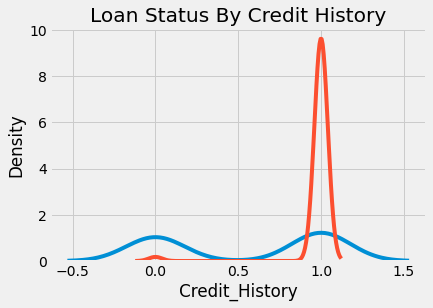

In [ ]:
plt.style.use('fivethirtyeight')

sns.kdeplot(data.loc[data.Loan_Status == 0, 'Credit_History'], label='Loan Status == 0')
sns.kdeplot(data.loc[data.Loan_Status == 1, 'Credit_History'], label='Loan Status == 1')

plt.title('Loan Status By Credit History')
plt.show()

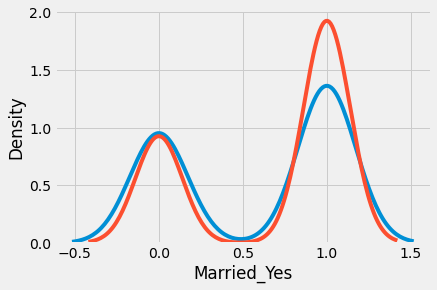

In [ ]:
sns.kdeplot(data.loc[data['Loan_Status'] == 0, 'Married_Yes'])
sns.kdeplot(data.loc[data['Loan_Status'] == 1, 'Married_Yes'])            

In [ ]:
data.columns

Index(['Education', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Gender_Female', 'Gender_Male',
       'Married_No', 'Married_Yes', 'Dependents_0', 'Dependents_1',
       'Dependents_2', 'Dependents_3+', 'Self_Employed_No',
       'Self_Employed_Yes', 'Property_Area_Rural', 'Property_Area_Semiurban',
       'Property_Area_Urban', 'Loan_Status', 'LoanTermBin', 'LoanAmountBin'],
      dtype='object')

In [ ]:
X = data.drop(columns=['Loan_Status'], axis=1)
y = data['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=7)

In [ ]:
rf = RandomForestClassifier(n_jobs=-1)

In [ ]:
xgb=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bytree=0.8, gamma=1.5, learning_rate=0.05, max_delta_step=0, max_depth=3, min_child_weight=7, missing=None, n_estimators=200, n_jobs=-1, nthread=None, objective='binary:logistic', random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=True, subsample=0.6)

In [ ]:
lgb_model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)

In [ ]:
ensemble = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb_model)], voting='soft')

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from collections import Counter

In [ ]:
X = X.drop(columns=[col for col in X.columns if "Loan_ID" in col])

In [ ]:
pipeline = Pipeline([('over', SMOTE()), ('under', RandomUnderSampler()), ('classifier', ensemble)])

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X=X.values, y=y, scoring='roc_auc', n_jobs=-1, cv=cv)
np.mean(scores)

0.757065046336772

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=.2, random_state=1)

In [ ]:
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Pipeline(memory=None,
         steps=[('over',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=None, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('under',
                 RandomUnderSampler(random_state=None, ratio=None,
                                    replacement=False, return_indices=False,
                                    sampling_strategy='auto')),
                ('classifier',...
                                                              learning_rate=0.05,
                                                              max_depth=-1,
                                                              min_child_samples=20,
                                                              min_child_weight=0.001,
                                                              min_split_gain=0.0,
   

In [ ]:
pipeline.score(X_test, y_test)

0.7886178861788617

In [ ]:
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
        

In [ ]:
ensemble.score(X_test, y_test)

0.8669950738916257

In [ ]:
xgb.score(X_test, y_test)

In [ ]:
kfold = KFold(5, True, 50)

In [ ]:
stratified_kfold = StratifiedKFold(5, True, 50)

In [ ]:
naive_b = GaussianNB()

In [ ]:
cross_val_score(ensemble, X, y, cv=stratified_kfold)

array([0.91625616, 0.93596059, 0.90147783, 0.8817734 , 0.91089109])

In [ ]:
naive_b.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
naive_b.score(X_test, y_test)

0.8211382113821138

In [ ]:
lgb_model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.05, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=10000,
               n_jobs=-1, num_leaves=31, objective='binary', random_state=50,
               reg_alpha=0.1, reg_lambda=0.1, silent=True, subsample=0.8,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
lgb_model.score(X_test, y_test)

0.8211382113821138

In [ ]:
kfold = KFold(5, True, 7)

In [ ]:
cross_val_score(lgb_model, X, y)

array([0.73170732, 0.74796748, 0.77235772, 0.74796748, 0.78688525])

In [ ]:
model.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
test['Loan_Status'] = ensemble.predict(test)
test['Loan_ID'] = test_ids
status_result = {0:'N', 1:'Y'}
test['Loan_Status'] = test['Loan_Status'].map(status_result)

In [ ]:
n = 9
test[['Loan_ID', 'Loan_Status']].to_csv('/content/gdrive/My Drive/Hackathons Analytics Vidhya/Loan Prediction/loan_prediction #' + str(n) + '.csv', index=False)

In [ ]:
for train, test in kfold.split(X):
	print('train: %s, test: %s' % (train, test))

In [ ]:
scaler = MinMaxScaler()

In [ ]:
for col in train:
  if len(list(data[col].unique())) 

(529, 30)

In [ ]:
def model(features, test_features, encoding='ohe', n_folds):
   """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """

    # Create the kfold object
    k_fold = KFold(n_splits=n_folds, shuffle=True, random_state=50)

    feature_importance_values = np.zeros(test_features)

In [ ]:
model.score(X_test, y_test)

0.8070175438596491

In [ ]:
sumission_sample

In [ ]:
for col in train:
  if data[col].dtype == int or data[col].dtype == float:
    if len(list(data[col].unique())) > 2:
      data[col] = scaler.fit_transform(data[col].values.reshape(-1,1))
      test[col] = scaler.transform(test[col].values.reshape(-1,1))          

In [ ]:
data['ApplicantIncome']

1      0.054830
2      0.035250
3      0.030093
4      0.072356
5      0.065145
         ...   
609    0.034014
610    0.048930
611    0.097984
612    0.091936
613    0.054830
Name: ApplicantIncome, Length: 529, dtype: float64

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D

In [ ]:
model = Sequential([
                    Dense(64, activation='relu'),
                    Dropout(.25),
                    Dense(16, activation='relu'),
                    Dropout(.25),
                    Dense(2, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=20)

In [ ]:
sumission_sample.head()

,Loan_ID,Loan_Status
0,LP001015,N
1,LP001022,N
2,LP001031,N
3,LP001035,N
4,LP001051,N


**Pipeline Practice**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['Loan_ID', 'Loan_Status'], axis=1), data['Loan_Status'].values, train_size=.8, random_state=0)

In [ ]:
numeric_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='median')),
  ('scaler', StandardScaler())])

In [ ]:
categorical_transformer = Pipeline(steps=[  
  ('imputer', SimpleImputer(strategy='constant')), 
  ('onehot', OneHotEncoder(handle_unknown='ignore'))])                                           

In [ ]:
numeric_features = data.select_dtypes([float, int]).columns

In [ ]:
numeric_features

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')

In [ ]:
categorical_features = data.select_dtypes([object]).drop(['Loan_ID', 'Loan_Status'], axis=1).columns

In [ ]:
categorical_features

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area'],
      dtype='object')

In [ ]:
preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_features), ('cat', categorical_transformer, categorical_features)])

In [ ]:
estimator = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', OneVsRestClassifier(LogisticRegression(max_iter=500)))])

In [ ]:
estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'classifier', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__feature_range', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__imputer', 'preprocessor__cat__onehot', 'preprocessor__cat__imputer__add_indicator', 'preprocessor__cat__imputer__copy', 'preproces

In [ ]:
param_grid = {'classifier__estimator__C': [.1, .5, 1]}

In [ ]:
model = GridSearchCV(estimator, param_grid, cv=5, n_jobs=-1, refit=False, scoring='f1_micro')

In [ ]:
model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [ ]:
model.best_params_['classifier__estimator__C']

0.5

In [ ]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', OneVsRestClassifier(LogisticRegression(max_iter=500, C=.5, n_jobs=-1)))])

In [ ]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

In [ ]:
clf.score(X_test, y_test)

0.8292682926829268

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
def best_thresholds(true, pred):
  thresholds = [ i /100 for i in range(100)]
  best_thresholds = []
  f1_scores = [f1_score(true, (pred > thresh) *1) for thresh in thresholds]
  return np.argmax(f1_scores)

In [ ]:
best_thresholds(y_test, clf.predict_proba(X_test))

ValueError: ignored

In [ ]:
convert_label = {'Y': 1, 'N':0}

Pipeline Practice 2

In [ ]:
data.head(2)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N


In [ ]:
data.drop('Loan_ID', axis=1, inplace=True)

In [ ]:
data['Loan_Status'] = data['Loan_Status'].apply(lambda x: {'Y':1, 'N': 0}[x])

In [ ]:
data['Loan_Status'].value_counts(normalize= True)

1    0.687296
0    0.312704
Name: Loan_Status, dtype: float64

In [ ]:
numeric_features = data.drop('Loan_Status', axis=1).select_dtypes([int, float]).columns
categorical_features = data.select_dtypes([object]).columns

In [ ]:
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                                       ('scaler', StandardScaler())])

In [ ]:
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
                                          ('onehot', OneHotEncoder())])

In [ ]:
preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_features), ('cat', categorical_transformer, categorical_features)])

In [ ]:
estimator = Pipeline(steps=[('preprocessor', preprocessor), ('onevsrest', OneVsRestClassifier(LogisticRegression(max_iter=500)))])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Loan_Status', axis=1), data['Loan_Status'], random_state=0)

In [ ]:
estimator.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                               

In [ ]:
param_grid = {'onevsrest__estimator__C': [.1, .3, .5]}
model = GridSearchCV(estimator, param_grid, scoring='f1_micro', cv=5)

In [ ]:
model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [ ]:
model.best_params_['onevsrest__estimator__C']

0.1

In [ ]:
clf = Pipeline(steps=[('preprocessor', preprocessor), ('onevsrest', OneVsRestClassifier(LogisticRegression(max_iter=500, C=0.1)))])

In [ ]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                               

In [ ]:
clf.score(X_test, y_test)

0.8376623376623377

In [ ]:
y_pred = clf.predict_proba(X_test)

In [ ]:
# Find best threshold to improve model accuracy
thresholds = [i / 100 for i in range(100)]
best_threshold = thresholds[np.argmax([f1_score(y_test, (y_pred[:, 1] > thresh) * 1) for thresh in thresholds])]
print(best_threshold)

0.57


In [ ]:
y_pred[:, 1] = (y_pred[:, 1] > best_threshold) * 1

In [ ]:
f1_score(y_test, y_pred[:, 1], average='micro')

0.8441558441558441

In [ ]:
clf.fit(data.drop('Loan_Status', axis=1), data['Loan_Status'])

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                               

In [ ]:
preds = clf.predict_proba(test)

/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [ ]:
preds = (preds[:, 1] > best_threshold) * 1

In [ ]:
test['Loan_Status'] = preds

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
test['Loan_Status'] = preds

In [ ]:
test.Loan_Status = test.Loan_Status.apply(lambda x: reverse_label_dict[x])

In [ ]:
test[['Loan_ID', 'Loan_Status']].to_csv('/content/gdrive/My Drive/Hackathons Analytics Vidhya/Loan Prediction/loan_prediction #10.csv', index=False)

In [ ]:
submission_sample.head()

,Loan_ID,Loan_Status
0,LP001015,N
1,LP001022,N
2,LP001031,N
3,LP001035,N
4,LP001051,N


In [ ]:
label_dict = {'Y':1, 'N': 0}
reverse_label_dict = {1: 'Y', 0: 'N'}

**Pipeline Practice #3**

In [ ]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:
y = data['Loan_Status']
X = data.drop(columns=['Loan_ID', 'Loan_Status'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [ ]:
numeric_features = X.select_dtypes([int, float]).columns
categorical_features = X.select_dtypes([object]).columns

In [ ]:
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')), ('onehot', OneHotEncoder())])

In [ ]:
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features), ('cat', categorical_transformer, categorical_features)])

In [ ]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
    ]

In [ ]:
 high_score = 0
 best_model = None
 for classifier in classifiers:
   pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)])
   pipe.fit(X_train, y_train)
   score = pipe.score(X_test, y_test)
   if score > high_score:
     high_score = score
     best_model = classifier
   print(classifier)
   print('Model score: %.3f' % score)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
Model score: 0.756
SVC(C=0.025, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Model score: 0.732
NuSVC(break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.5, probability=True, random_state=None, shrinking=True,
      tol=0.001, verbose=False)
Model score: 0.829
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                  

In [ ]:
best_model

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [ ]:
ada = Pipeline(steps=[('preprocessor', preprocessor), ('ada', AdaBoostClassifier(algorithm="SAMME.R", random_state=0, learning_rate=1.1))]) 

In [ ]:
ada.fit(X, y)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                               

In [ ]:
preds = ada.predict(test.drop('Loan_ID', axis=1))

In [ ]:
test['Loan_Status'] = preds

In [ ]:
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban,Y
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban,Y
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban,Y
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban,Y
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban,Y


In [ ]:
test[['Loan_ID', 'Loan_Status']].to_csv(path.replace('Data/', 'loan_prediction #13.csv'), index=False)

In [ ]:
nusvc = Pipeline(steps=[('preprocessor', preprocessor),('nusvc', NuSVC(probability=True))])

In [ ]:
nusvc.fit(X, y)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                               

In [ ]:
preds = nusvc.predict(test.drop(['Loan_ID', 'Loan_Status'], axis=1))

In [ ]:
rf = RandomForestClassifier(n_jobs=-1)
xgb=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bytree=0.8, gamma=1.5, learning_rate=0.05, max_delta_step=0, max_depth=3, min_child_weight=7, missing=None, n_estimators=200, n_jobs=-1, nthread=None, objective='binary:logistic', random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=True, subsample=0.6)
lgb_model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
ada = AdaBoostClassifier()
gbc = GradientBoostingClassifier()

In [ ]:
X = data.drop(columns=['Loan_ID', 'Loan_Status'], axis=1)
y = data['Loan_Status']

In [ ]:
numberic_features = X.select_dtypes([int, float]).columns
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer()),('scaler', StandardScaler())])

categorical_features = X.select_dtypes(object).columns
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),('onehot', OneHotEncoder())])

In [ ]:
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numberic_features), ('cat', categorical_transformer, categorical_features)])

In [ ]:
model = Pipeline([('preprocessor', preprocessor), ('ensemble', VotingClassifier([('rf', rf), ('xgb', xgb), ('lgb', lgb_model)]))])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=0)

In [ ]:
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                               

In [ ]:
test['Loan_Status'] = model.predict(test.drop(['Loan_ID'], axis=1))

In [ ]:
model.score(X_test, y_test)

0.8048780487804879

In [ ]:
boot = resample(data, replace=True, n_samples=400, random_state=7)

In [ ]:
boot_data = pd.concat([data, boot])

In [ ]:
data.shape, boot_data.shape

((614, 13), (1014, 13))

In [ ]:
cv = StratifiedKFold(shuffle=True, random_state=0)

In [ ]:
cross_val_score(model, X, y, cv=cv, scoring='f1_micro')

array([0.81300813, 0.74796748, 0.81300813, 0.7398374 , 0.83606557])

**Custom Imputer To Improve Performance**

In [ ]:
data.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [ ]:
class LoanPredictionImputer(BaseEstimator, TransformerMixin):
  '''
  Class used for imputing missing values on the loan prediction problem
  '''
  def __init__(self, strategy):
    assert strategy in ['cat', 'num'], 'strategy must be either cat or num'
    self.strategy = strategy

  def fit(self, X, y=None):
    #assert pd.isnull(X[self.cat_cols]).any(axis=None) == False, 'There are missing values'
    return self

  def transform(self, X, y=None ):
    if self.strategy == 'cat':
      X.loc[X.Gender.isna(), 'Gender'] = "Gender_Missing"
      X.loc[X.Married.isna(), 'Married'] = X.Married.mode()[0]
      X.loc[X.Dependents.isna(), 'Dependents'] = X.Dependents.mode()[0]
      X.loc[X.Self_Employed.isna(), "Self_Employed"] = 'Self_Employed_Missing'
    if self.strategy == 'num':
      X.loc[X.LoanAmount.isna(), 'LoanAmount'] = X.LoanAmount.median()
      X.loc[X.Loan_Amount_Term.isna(), 'Loan_Amount_Term'] = X.Loan_Amount_Term.median()
      X.loc[X.Credit_History.isna(), "Credit_History"] = 2
      #X.Credit_History = X.Credit_History.replace({0.0: 'Credit_No', 1.0: 'Credit_Yes', 2.0: 'Credit_Missing'})
    return X

In [ ]:
X = data.drop(['Loan_ID', 'Loan_Status'], axis=1)
y = data['Loan_Status']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [ ]:
numeric_cols = X.select_dtypes([int, float]).columns.to_list()
categorical_cols = X.select_dtypes(object).columns.to_list()

In [ ]:
numeric_transformer = Pipeline([('imputer', LoanPredictionImputer(strategy='num')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline([('imputer', LoanPredictionImputer(strategy='cat')), ('onehot', OneHotEncoder())])

In [ ]:
preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_cols), ('cat', categorical_transformer, categorical_cols)])

In [ ]:
ensemble = VotingClassifier([('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bytree=0.8, gamma=1.5, learning_rate=0.05, max_delta_step=0, max_depth=3, min_child_weight=7, missing=None, n_estimators=200, n_jobs=-1, nthread=None, objective='binary:logistic', random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=True, subsample=0.6)), ('gbc', GradientBoostingClassifier()), ('ada', AdaBoostClassifier(algorithm="SAMME.R", random_state=0, learning_rate=1.1))])

In [ ]:
model = Pipeline([('preprocessor', preprocessor), ('ensemble', ensemble)])

In [ ]:
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   LoanPredictionImputer(strategy='num')),
                                                                  ('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
    

In [ ]:
model.score(X_test, y_test)

0.8130081300813008

In [ ]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:
X = data.drop(columns=['Loan_ID', 'Loan_Status'], axis=1)

In [ ]:
y = data['Loan_Status']

In [ ]:
numeric_features = X.select_dtypes([int, float]).columns
categorical_features = X.select_dtypes([object]).columns

In [ ]:
numeric_transformer = Pipeline([('imputer', SimpleImputer()), ('scaler', StandardScaler())])
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant')), ('onehot', OneHotEncoder())])

In [ ]:
preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_features), ('cat', categorical_transformer, categorical_features)])

In [ ]:
estimator = Pipeline([('preprocessor', preprocessor), ('resampler', resample(X, y, random_state=0)), ('onevsrest', OneVsRestClassifier(LogisticRegression(max_iter=500, n_jobs=-1)))])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=0)

In [ ]:
param_grid = {'onevsrest__estimator__C': [.3, .6, 1]}

In [ ]:
model = GridSearchCV(estimator, param_grid, scoring='f1_micro')

In [ ]:
estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'onevsrest', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__imputer', 'preprocessor__cat__onehot', 'preprocessor__cat__imputer__add_indicator', 'preprocesso

In [ ]:
model.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                 

In [ ]:
clf = Pipeline([('preprocessor', preprocessor), ('onevsrest', OneVsRestClassifier(LogisticRegression(max_iter=500, n_jobs=-1, C=.3)))])

In [ ]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                               

In [ ]:
clf.score(X_test, y_test)

0.8373983739837398

In [ ]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:
data.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [ ]:
class GenderImputer():
  def __init__(self, func):
    self.func = func

  def transform(self, input_df, **transform_params):
    return self.func(input_df)
  
  def fit(self, X, y=None, **fit_params):
    return self

In [ ]:
def impute_missing_gender(input_df):
  input_df['Gender'] = input_df.loc[input_df['Gender'].isna()] = "Male"
  return input_df

In [ ]:
pipeline = Pipeline([('genderimpute', GenderImputer(impute_missing_gender))])

In [ ]:
pipeline.fit_transform(data)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0,NaN,360,1,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508,128,360,1,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0,66,360,1,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358,120,360,1,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0,141,360,1,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Male,No,0,Graduate,No,2900,0,71,360,1,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0,40,180,1,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240,253,360,1,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0,187,360,1,Urban,Y


In [ ]:
data.isna().sum()

Loan_ID               0
Gender                0
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [ ]:
import re
''.join(re.split('[^0-9]', "059a"))

'059'

In [ ]:
class Luhn:
    def __init__(self, card_num):
        self.card_num = ''.join(re.split('[^0-9]', card_num))
        self.card_num = [int(x) for x in self.card_num]

    def valid(self):
        if len(self.card_num) < 2:
            return False
        # double every second number starting fromt he end
        for i in range(len(self.card_num) -2,-1, -2):
            new_num = self.card_num[i] * 2
            # if doubled number is greater than 9, subtract 9
            if new_num > 9:
                new_num -= 9
            self.card_num[i] = new_num
        total_sum = 0
        print (self.card_num)
        for num in self.card_num:
            # check to ensure the sum is divisible by 10
            total_sum += num
        print(total_sum)
        return int(total_sum) % 10 == 0

In [ ]:
l = Luhn("055# 444$ 285")
l.card_num

[0, 5, 5, 4, 4, 4, 2, 8, 5]

In [ ]:
l.valid()

[0, 1, 5, 8, 4, 8, 2, 7, 5]
40


True

In [ ]:
for i in range(len(l.card_num) -2, -1, -2):
  print(i)

11
9
7
5
3
1


In [ ]:
keras.wrappers.scikit_learn.

In [ ]:
grades = {2: ["Jeremy", "Dog", 'Becky'], 3: ['Nick', 'Alicee'], 1: ['Zee','Apple', 'Brian']}

In [ ]:
[x[1] for x in sorted(grades.items(), key=lambda x: (x[0], x[1]), reverse=False)]

[['Zee', 'Apple', 'Brian'], ['Jeremy', 'Dog', 'Becky'], ['Nick', 'Alicee']]

In [ ]:
[v for k in sorted(grades.keys()) for v in sorted(grades[k]) ]

['Apple', 'Brian', 'Zee', 'Becky', 'Dog', 'Jeremy', 'Alicee', 'Nick']

In [ ]:
url = 'https://www.nytimes.com/interactive/2020/11/03/us/elections/results-president.html?action=click&pgtype=Article&state=default&module=styln-elections-2020&region=TOP_BANNER&context=election_recirc'

In [ ]:
import re

In [ ]:
test_sent = "the_quick_brown_fox_jumps_over_the_lazy_dog"

In [ ]:
len("Team                           ")

31

In [ ]:
dna = ["GTCAT"]

In [ ]:
import re
isbn = "3-598-21508-8"
isbn = re.sub('[^0-9X]+', '', isbn)    
numbers = [int(n) if n != 'X' else 10 for n in isbn]

In [ ]:
"359829507".index('X')

ValueError: ignored

In [ ]:
def get_rna(nucleotide):
  rna = {'G' : 'C', 'C' : 'G', 'T' : 'A', 'A' : 'U'}
  return rna[nucleotide]

In [ ]:
from numpy import std, mean
import numpy as np
from numpy.random import randn
from numpy import sqrt

In [ ]:
data = 5 * randn(10000) + 50

In [ ]:
data

array([55.29511377, 53.42746086, 50.08874525, ..., 47.97317559,
       52.61052542, 52.22223216])

In [ ]:
data_mean, data_std =mean(data), std(data)

cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off

outliers = [x for x in data if x < lower or x > upper ]
print(outliers)

[32.56939326536422, 25.62038160332981, 65.12249092387289, 68.59834308957957, 68.09045681728057, 32.52508055578335, 70.94436976103202, 34.119006630545655, 34.36817640576001, 67.37443939109946, 66.037968044508, 34.312397632243176, 66.62900476897327, 34.33909576082275, 34.337589871218825, 32.182895048613545, 30.732214250172632, 32.984845980792464, 31.528993903876035, 67.24267071220794, 65.99337540669364, 66.67912969014651, 67.08841568809532, 67.61085010175101, 33.73702812188358, 34.280902969893134, 65.58730727212776, 34.23258563647156, 67.58794727996197, 66.32527759973928, 34.77936635319437, 33.444431584349616, 33.69857979655326, 34.37456879292887]


In [ ]:
non_outliers = [x for x in data if x > lower and x < upper]

In [ ]:
len(data), len(outliers), len(non_outliers)

(10000, 34, 9966)

**Interquartile Range Method**

In [ ]:
q25, q75 = np.percentile(data, 25), np.percentile(data, 75)
iqr = q75 - q25

In [ ]:
iqr

6.789952435421512

In [ ]:
# Calculate the outlier cutoff
cutoff = iqr * 1.5
lower, upper = q25 - cutoff, q75 + cutoff

In [ ]:
# identify outliers
outliers = [x for x in data if x < lower or x < upper]

In [ ]:
outliers_removed = [x for x in data if x < lower or x > upper]

In [ ]:
len(outliers_removed)

85

In [ ]:
len(outliers)

9947

In [ ]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:
X = data.drop(columns=['Loan_ID', 'Loan_Status'], axis=1)
y = data['Loan_Status']

In [ ]:
numeric_transformer = Pipeline([('imputer', SimpleImputer()), ('scaler', StandardScaler())])
numeric_cols = X.select_dtypes([int, float]).columns

categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant')), ('onehot', OneHotEncoder())])
categorical_cols = X.select_dtypes([object]).columns

In [ ]:
preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_cols),('cat', categorical_transformer, categorical_cols)])

In [ ]:
X_transformed = preprocessor.fit_transform(X)

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y)

In [ ]:
model = XGBClassifier()

In [ ]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
yhat = model.predict(X_test)

In [ ]:
model.score(X_test, y_test)

0.7727272727272727

In [ ]:
lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train)

In [ ]:
mask = yhat != -1

In [ ]:
mask.valu

AttributeError: ignored

In [ ]:
len(mask), len(X_train)

(460, 460)

In [ ]:
X_train2, y_train2 = X_train[mask, :], y_train[mask]

In [ ]:
model = XGBClassifier()
model.fit(X_train2, y_train2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
model.score(X_test, y_test)

0.7727272727272727

In [ ]:
class Node:

  def __init__(self, data):
    self.right = None
    self.left = None
    self.data = data

  def insert(self, value):
    if (value <= self.data):
      if self.left == None:
        self.left = Node(value)
      else:
        self.left.insert(value)
    else:
      if self.right == None:
        self.right = Node(value)
      else:
        self.right.insert(value) 

  def contains(self, value):
    if value == self.data:
      return True
    elif value < data:
      if self.left == None:
        return False
      else:
        return self.left.contains(value)
    else:
      if self.right == None:
        return False
      else:
        return self.right.contains(value)

  def printInOrder(self):
    if self.left != None:
      self.left.printInOrder()
    print(self.data)
    if self.right != None:
      self.right.printInOrder()


  def printPreOrder(self):
    print(self.data)
    if self.left != None:
      self.left.printPreOrder()
    if self.right != None:
      self.right.printPreOrder()

  def printPostOrder(self):
    if self.left != None:
      self.left.printPostOrder()
    if self.right != None:
      self.right.printPostOrder()
    print(self.data)
    

In [ ]:
node = Node(10)

node.insert(5)
node.insert(15)
node.insert(8)

In [ ]:
node.printInOrder()

5
8
10
15


In [ ]:
node.printPreOrder()

10
5
8
15


In [ ]:
node.printPostOrder()

8
5
15
10


In [ ]:
import numpy as np
data = [21,50, 62, 85, 90]
mu = np.mean(data)
variance = sum([(x - mu)**2 for x in data]) / len(data)

In [ ]:
np.std(data)

25.048752463945185

In [ ]:
np.sqrt(variance)

25.048752463945185

In [ ]:
mylist = [2,2,4,3,5]

In [ ]:
from collections import Counter

In [ ]:
counts = Counter(mylist)

In [ ]:
len(counts.items())

4

In [ ]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

In [ ]:
data = {"People": [100, 200, 300, 400, 450, 475, 550], "Sales": [2000, 2345, 2500, 2798, 3100, 3500, 4200]}

In [ ]:
data = pd.DataFrame(data)

In [ ]:
data.head()

,People,Sales
0,100,2000
1,200,2345
2,300,2500
3,400,2798
4,450,3100


In [ ]:
model = LinearRegression()

In [ ]:
model.fit(data['People'].values.reshape(-1,1), data['Sales'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
model.coef_

array([4.35680827])

In [ ]:
yhat = model.predict(data['People'].values.reshape(-1,1))

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
from statsmodels.api import OLS
OLS(data.Sales,data.People).fit().summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Sales   R-squared (uncentered):                   0.961
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                              149.4
Date:                Wed, 30 Dec 2020   Prob (F-statistic):                    1.82e-05
Time:                        17:03:11   Log-Likelihood:                         -54.591
No. Observations:                   7   AIC:                                      111.2
Df Residuals:                       6   BIC:                                      111.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
People         7.6708      0.628     12.224      0.000       6.135       9.206
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.344
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.972
Skew:                           0.811   Prob(JB):                        0.615
Kurtosis:                       2.162   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
odds1 = round(.396-(.173*4.5) + 1.555, 4)
odds2 = round(.396-(.173*4.5), 4)

In [ ]:
odds1

3.78

In [ ]:
odds2

8.51

In [ ]:
prob = odds / (1 + odds)

In [ ]:
prob

0.40552406925175993

In [ ]:
log_odds = round(.396-(.173*4.5), 4)

In [ ]:
odds_ratio = exp(odds1) / exp(odds2)

In [ ]:
odds_ratio

4.735086525159423

In [ ]:
def encode(string):
    encoding = ""
    current_letter = ""
    letter_count = 0
    for letter in string:
        if current_letter != letter:
            if letter_count > 1:
                encoding += str(letter_count)
            encoding += current_letter
            current_letter = letter
            letter_count = 1
        else:
            letter_count += 1
    return encoding

In [ ]:
encode("WWWWWWWWWWWWBWWWWWWWWWWWWBBBWWWWWWWWWWWWWWWWWWWWWWWWB")

'12WB12W3B24W'

In [ ]:
import re

In [ ]:
def decode(string):
    decoded_string = ""
    number = 1
    i = 0
    while i < len(string):
        if len(re.findall("[0-9]", string[i])) > 0:
            number = int(re.findall("[0-9]", string[i])[0])
            i += 1
            if len(re.findall("[0-9]", string[i])) > 0:
                number = number * 10 + int(re.findall("[0-9]", string[i])[0])
                i += 1
        else:
            number = 1
        decoded_string += string[i] * number
        i += 1
    return decoded_string

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
nums = np.array([2, 3,4,5,7,7,8,9,12, 13, 14,14,17,19,33, 34, 35, 39, 44, 51, 53, 55,61, 66,67,68,72])

{'boxes': [<matplotlib.lines.Line2D at 0x7f96072658d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f9607271320>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9607271da0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f9607271a20>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f9607265be0>,
  <matplotlib.lines.Line2D at 0x7f9607265f60>]}

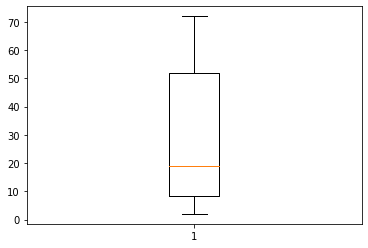

In [ ]:
plt.boxplot(nums)

In [1]:
def slices(series, length):
    assert len(series) >= length, ValueError("Series length must be longer than slice length")
    assert len(series) > 0, ValueError("Series length must be longer than 0 numbers")
    assert length > 0, ValueError("Length must be larger than 0")

    slice = list()
    i = 0
    while i + length <= len(series):
        slice.append(series[i:i + length])
        i += 1
    return slice


In [5]:
slices("12345", 2)

['12', '23', '34', '45']